In [136]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

np.random.seed(1)
ticker = "BAC"

# Open the AAPL stock file from the ticker_data dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"
df = pd.read_csv(f"{TICKER_DIR}\\{ticker}.csv", header=0)

print(df.shape)

# Our target is the close price of the stock
target = df["close"].tail(1000)
dataset = df[["high", "low", "open"]].tail(1000)

(1006, 13)


In [137]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i, _ in enumerate(sequences):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 3

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open, high, low, close))
# split sequences
sc = MinMaxScaler()
# d_sc = sc.fit_transform(d)
# X, y = split_sequences(d_sc, n_steps)
X, y = split_sequences(d, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)



(1000, 4)
(998, 3, 4)
(998, 4)


In [138]:
# clears previous sessions
keras.backend.clear_session()
# create a Sequential model, 2 LSTM 100 node layers & 1 fully connected layer
model = Sequential()
model.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation="relu"))
model.add(Dense(n_features))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mae", metrics=["accuracy"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

training_history = model.fit(X_train, y_train, epochs=500, verbose=2)

 - accuracy: 0.7694
Epoch 131/500
 - 0s - loss: 0.1247 - accuracy: 0.9135
Epoch 132/500
 - 0s - loss: 0.1560 - accuracy: 0.9023
Epoch 133/500
 - 0s - loss: 0.1935 - accuracy: 0.9223
Epoch 134/500
 - 0s - loss: 0.1504 - accuracy: 0.8609
Epoch 135/500
 - 0s - loss: 0.1227 - accuracy: 0.9273
Epoch 136/500
 - 0s - loss: 0.1822 - accuracy: 0.8797
Epoch 137/500
 - 0s - loss: 0.2071 - accuracy: 0.7494
Epoch 138/500
 - 0s - loss: 0.1632 - accuracy: 0.9461
Epoch 139/500
 - 0s - loss: 0.1570 - accuracy: 0.9561
Epoch 140/500
 - 0s - loss: 0.1137 - accuracy: 0.9173
Epoch 141/500
 - 0s - loss: 0.1246 - accuracy: 0.8797
Epoch 142/500
 - 0s - loss: 0.1205 - accuracy: 0.8922
Epoch 143/500
 - 0s - loss: 0.1362 - accuracy: 0.8459
Epoch 144/500
 - 0s - loss: 0.1275 - accuracy: 0.8772
Epoch 145/500
 - 0s - loss: 0.1191 - accuracy: 0.8985
Epoch 146/500
 - 0s - loss: 0.1278 - accuracy: 0.8935
Epoch 147/500
 - 0s - loss: 0.1224 - accuracy: 0.9248
Epoch 148/500
 - 0s - loss: 0.1901 - accuracy: 0.8045
Epoch 14

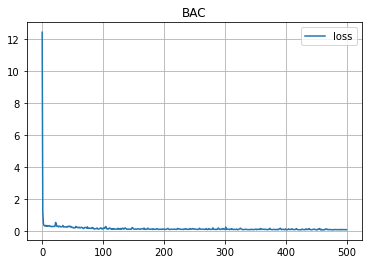

In [139]:
plt.plot(model.history.history["loss"], label="loss")
plt.grid()
plt.legend()
plt.title(ticker)
plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\losses\\{ticker}.png")

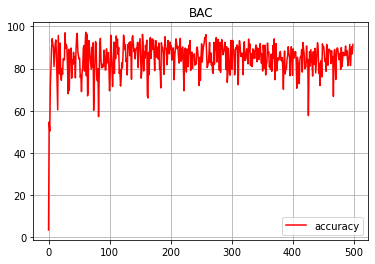

In [140]:
plt.plot(np.array(model.history.history["accuracy"])*100, label="accuracy", color="red")
plt.grid()
plt.legend()
plt.title(ticker)
plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\accuracies\\{ticker}.png")

In [141]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")
scores

History Item [loss] reports value of 0.06723354816436768
History Item [accuracy] reports value of 0.9200000166893005


[0.06723354816436768, 0.9200000166893005]

In [142]:
actual = y_test[:, -1]
yhat = model.predict(X_test, verbose=0)
yhat.shape
predictions = yhat[:, -1]

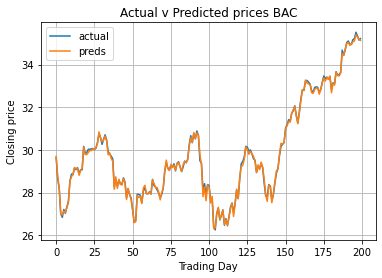

In [143]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title(f"Actual v Predicted prices {ticker}")
plt.ylabel("Closing price")
plt.xlabel("Trading Day")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid()
plt.legend()
plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\{ticker}.png")